In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai2.tabular.all import *
from fastai2.imports import *

In [3]:
from fastai2.layers import L1LossFlat

In [4]:
from utils import *

In [7]:
path=Path('ftbl-data')

In [10]:
whole_df = pd.read_pickle(path/'trans_over_1000_final.pkl')

In [11]:
cat_vars_tpl = ('season','trs_year','trs_month','trs_day','trs_till_deadline',
            'contract_left_months', 'contract_left_years','age',
            'is_midseason','is_loan','is_end_of_loan',
            'nat_national_name','plr_position_main',
            'plr_other_positions','plr_nationality_name',
            'plr_other_nationality_name','plr_place_of_birth_country_name',
            'plr_foot','plr_height','plr_player_agent','from_club_name','from_club_is_first_team',
            'from_clb_place','from_clb_qualified_to','from_clb_is_champion','from_clb_is_cup_winner',
            'from_clb_is_promoted','from_clb_lg_name','from_clb_lg_country','from_clb_lg_group',
            'from_coach_name', 'from_sport_dir_name',
            'to_club_name','to_club_is_first_team','to_clb_place','to_clb_qualified_to',
            'to_clb_is_champion','to_clb_is_cup_winner','to_clb_is_promoted','to_clb_lg_name','to_clb_lg_country',
            'to_clb_lg_group','to_coach_name', 'to_sport_dir_name',
            'plr_position_0','plr_position_1','plr_position_2',
            'stats_leag_name_0','stats_leag_grp_0','stats_leag_name_1','stats_leag_grp_1','stats_leag_name_2',
            'stats_leag_grp_2')

In [12]:
cont_vars_tpl = ('nat_months_from_debut','nat_matches_played','nat_goals_scored','from_clb_pts_avg',
             'from_clb_goals_diff_avg','to_clb_pts_avg','to_clb_goals_diff_avg','plr_apps_0',
             'plr_apps_1','plr_apps_2','stats_made_goals_0','stats_conc_gols_0','stats_cards_0',
             'stats_minutes_0','stats_team_points_0','stats_made_goals_1','stats_conc_gols_1',
             'stats_cards_1','stats_minutes_1','stats_team_points_1','stats_made_goals_2',
             'stats_conc_gols_2','stats_cards_2','stats_minutes_2','stats_team_points_2', 'pop_log1p')

In [13]:
cat_vars = list(cat_vars_tpl)
cont_vars = list(cont_vars_tpl)
all_vars = cat_vars + cont_vars

#### prepare

In [14]:
list_diff(whole_df.columns, cat_vars, cont_vars)

['player_name',
 'market_value',
 'fee',
 'is_future_transfer',
 'plr_place_of_birth_name']

We throw away: effectively unique values ('player_name','plr_place_of_birth_name'), constants ('is_future_transfer' as we have no future transfers here anymore) or values we don't want to use now (transfermarkt's 'market_value')

In [15]:
dep_var = 'fee'

In [16]:
df = whole_df[all_vars + [dep_var]].copy()

In [17]:
df[f"{dep_var}_orig"] = df[f"{dep_var}"].copy()
df[dep_var] = np.log(df[dep_var])

In [18]:
np.random.seed(1001)
ln = len(df)
valid_idx = np.random.choice(ln, int(ln*0.2), replace=False)
train_idx = np.array(list_diff(list(range(ln)), valid_idx))

In [19]:
L(list(valid_idx)), L(list(train_idx))

((#1952) [3059,8006,4942,3346,9351,2891,5024,1180,6588,439...],
 (#7809) [0,1,2,3,4,5,7,8,9,11...])

In [20]:
procs=[FillMissing, Categorify, Normalize]

In [21]:
min_log_y = np.log(500)
max_log_y = np.max(df[dep_var])*1.2
y_range = torch.tensor([min_log_y, max_log_y], device=default_device())
y_range

tensor([ 6.2146, 14.7725], device='cuda:0')

In [22]:
def exp_mmape(pred:Tensor, targ:Tensor):
    "Exp mean absolute percentage error between `pred` and `targ`."
    pred,targ = flatten_check(pred,targ)
    pred, targ = torch.exp(pred), torch.exp(targ)
    pct_var = (targ - pred)/targ
    return torch.abs(pct_var).mean()

In [23]:
BS = 128

In [24]:
layers = [1000,500]
layers_drop = [0.07, 0.7]
emb_drop = 0.7
cycles = 40
w_decay = 0.7
max_lr = 1e-3

In [25]:
ds = TabularPandas(df=df,
                  procs=procs,
                  cat_names=cat_vars,
                  cont_names=cont_vars,
                  y_names=dep_var,
                  y_block=RegressionBlock(),
                  splits=(list(train_idx), list(valid_idx)),
                  inplace=False,
                  reduce_memory=False)

In [26]:
dls = ds.dataloaders(bs=BS)

In [27]:
np.random.seed(1001)
learn = tabular_learner(dls=dls,
                       layers=layers,
                       ps=layers_drop,
                       y_range=y_range, 
                       metrics=exp_mmape,
                       loss_func=exp_mmape,
                       wd=w_decay)

SuggestedLRs(lr_min=0.2290867567062378, lr_steep=0.0006918309954926372)

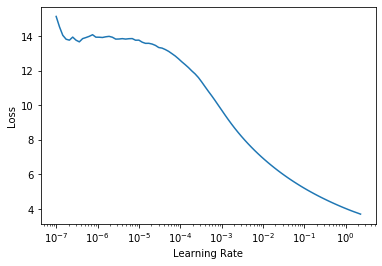

In [28]:
learn.lr_find()

In [29]:
learn.fit_one_cycle(n_epoch=cycles, max_lr=max_lr, wd=w_decay)

epoch,train_loss,valid_loss,exp_mmape,time
0,5.004932,7.428215,7.428215,00:01
1,1.581562,0.516851,0.516851,00:01
2,0.716264,0.526602,0.526602,00:01
3,0.440615,0.508337,0.508337,00:01
4,0.362725,0.506861,0.506861,00:01
5,0.361564,0.487077,0.487077,00:01
6,0.382285,0.534076,0.534076,00:01
7,0.403187,0.514997,0.514997,00:01
8,0.405154,0.504891,0.504891,00:01
9,0.395371,0.483766,0.483766,00:01


In [30]:
export_path = path/"exports"

In [31]:
learn.export(export_path/"ftbl_483_mean")

#### Compare with transfermarkt

In [43]:
def get_error(pred, targ):
    acc = exp_mmape(pred=tensor(pred).double(), targ=tensor(targ).double())
    return int(float(acc)*100)

In [33]:
valid_df = whole_df.iloc[valid_idx]

In [36]:
valid_df_no_loans = valid_df.query('is_loan == False')

In [37]:
actuals_l = np.array(np.log1p(valid_df_no_loans['fee']))

In [38]:
tm_preds_l =  np.array(np.log1p(valid_df_no_loans['market_value']))

In [39]:
dl = learn.dls.test_dl(valid_df_no_loans)
model_preds_l = np.array(learn.get_preds(dl=dl)[0].T[0])

In [40]:
nan_idx = np.argwhere(np.isnan(tm_preds_l))
correct_idx = list_diff(range(0,len(actuals_l)), list(nan_idx.T[0]))
len(nan_idx)

347

In [41]:
actuals_l = actuals_l[correct_idx]
tm_preds_l = tm_preds_l[correct_idx]
model_preds_l = model_preds_l[correct_idx]

In [44]:
tm_error = get_error(pred=tm_preds_l, targ=actuals_l)
model_error = get_error(pred=model_preds_l, targ=actuals_l)

In [45]:
results = {'transfermarkt':tm_error, 'model':model_error}
results

{'transfermarkt': 47, 'model': 46}

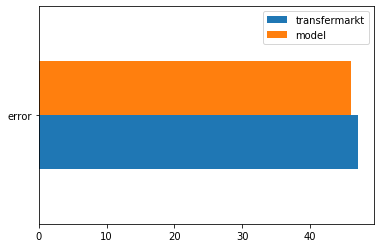

In [47]:
results = pd.DataFrame(results, index=['error'])
results.plot.barh()

As we see even without loans (cause there are no relevant value from transfermarkt to predict loans) our model is equal (and even slightly better) to transfermart predictions